In [86]:
import networkx as nx 
import random
import matplotlib.pyplot as plt
import numpy as np 
import math 
import copy 
import graphviz
from scipy.optimize import fsolve
from typing import List
import sympy as sp
from sympy import Symbol
from collections import deque

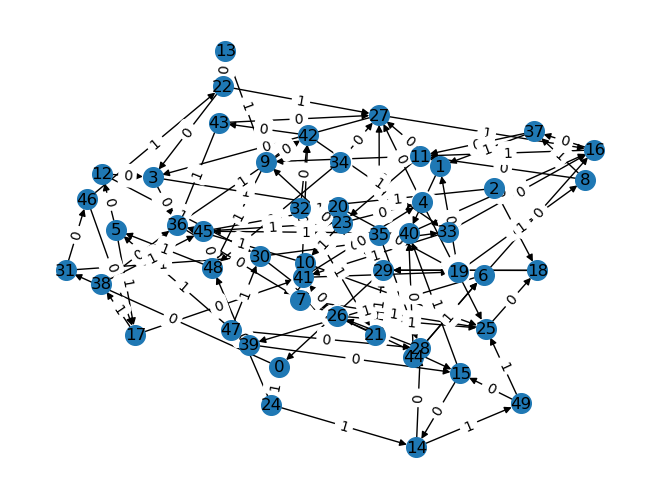

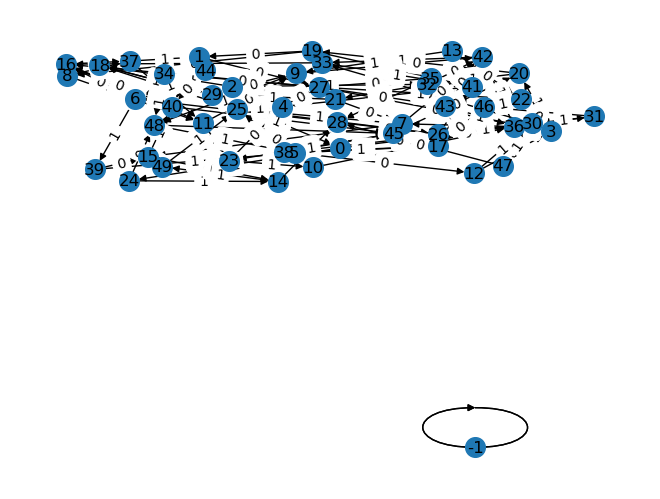

Even Successors: [31, 27, 18, 36, 27, 12, 16, 42, 11, 42, 25, 9, 3, 22, 28, 14, 37, 41, 29, 1, 19, 7, 3, 4, 48, 18, 41, 3, 26, 9, 33, 46, 42, 16, 27, 27, 7, 11, 36, 15, 16, 4, 43, 27, 40, 20, 17, 28, 45, 15, -1]
Odd Successors: [24, 40, 32, 20, 25, 17, 39, 15, 37, 48, 36, 23, 30, 9, 49, 40, 11, 38, 29, 8, 32, 29, 27, 10, 14, 7, 25, 16, 6, 0, 26, 30, 21, 41, 48, 28, 42, 1, 45, 5, 45, 19, 33, 36, 6, 23, 22, 30, 5, 25, -1]
Current Switches: [31 27 18 36 27 12 16 42 11 42 25  9  3 22 28 14 37 41 29  1 19  7  3  4
 48 18 41  3 26  9 33 46 42 16 27 27  7 11 36 15 16  4 43 27 40 20 17 28
 45 15 -1]
Next Switches: [24 40 32 20 25 17 39 15 37 48 36 23 30  9 49 40 11 38 29  8 32 29 27 10
 14  7 25 16  6  0 26 30 21 41 48 28 42  1 45  5 45 19 33 36  6 23 22 30
  5 25 -1]

In [368]:
class Arrival():
    
    def __init__(self,n):
        self.n = n # number of nodes
        self.vertices = [v for v in range(n)] # zero is origin and n is the destination 
        self.s_0 = np.array([random.choice([i for i in range(n) if i != v]) for v in self.vertices])  # even successors
        self.s_1 = np.array([random.choice([i for i in range(n) if i != v]) for v in self.vertices])  # odd successors
      
        # Some edges can have both successor as themselves, acting as sinks. should this be allowed??
        self.start_node = 0 # current node 
        self.target_node = n-1
        
        # Construct Graph Structure and Equations for node visit counts
        self.raw_graph = self.get_network_graph()
        self.draw_graph(self.raw_graph)
        
        self.graph = self.combine_unreachable_nodes()
        self.s_0, self.s_1 = self.update_successor_list(self.s_0,self.s_1)
        self.X,self.equations = self.get_equations()
        
        self.s_curr = np.copy(self.s_0) # current switches for each node
        self.s_next = np.copy(self.s_1) # next switch for each node
        
        self.draw_graph(self.graph)
        
    
    def __repr__(self):
        return f"Even Successors: {self.s_0}\nOdd Successors: {self.s_1}\nCurrent Switches: {self.s_curr}\nNext Switches: {self.s_next}"
    
    def update_successor_list(self,s_0,s_1):
        ## now the successor lists is 0 indexed with last element being the successors for -1
        new_s0, new_s1 = [-1]*self.n, [-1]*self.n
        for node in self.graph.nodes:
            if node == -1:
                continue
            
            for source,target,attr in self.graph.out_edges(node,data=True):
                # print(edge)
                label = attr['label']
                # print(node ,edge, label)
                
                if label == '1':
                    new_s1[node] = target
                elif label == '0':
                    new_s0[node] = target     
        # print(new_s1) 
        return new_s0,new_s1
        
    def get_network_graph(self):
        G = nx.MultiDiGraph()
        G.add_nodes_from(self.vertices, d_dash=False)
        
        for v in self.vertices:
            G.add_edge(v,self.s_0[v],label='0')
            G.add_edge(v,self.s_1[v],label='1')
            
        return G
        
    def combine_unreachable_nodes(self):
        # reachable_nodes = nx.descendants(self.raw_graph, self.start_node) | {self.start_node}
        reachable_nodes = nx.ancestors(self.raw_graph, self.target_node) | {self.target_node}

        new_G = nx.MultiDiGraph()
        mapping = {}
        counter = 0
        for node in self.raw_graph.nodes():
            if node in reachable_nodes:
                mapping[node] = counter ### to reset the node number we add counter
                counter += 1
            else:
                # print(f'removing node {node}')
                mapping[node] = -1
        # print(mapping)
        new_G.add_node(-1)

        for source, target, attr in self.raw_graph.edges(data=True):

            if source in reachable_nodes and target in reachable_nodes:
                new_G.add_edge(mapping[source], mapping[target],label=attr['label'])
            elif source in reachable_nodes:
                new_G.add_edge(mapping[source], -1,label=attr['label'])
                

        new_G.add_edge(-1, -1,label = '1')
        new_G.add_edge(-1, -1,label = '0')
        
        ## Changing the vertices
        self.vertices = list(new_G.nodes)
        self.n = len(self.vertices)
        self.target_node = self.n-2 
        
        # print(n)
        return new_G

    def get_equations(self):
        symbol_nodes = list(self.graph.nodes)
        symbol_nodes.sort()
        
        symbols = sp.symbols(' '.join([f"X{i}" for i in symbol_nodes]),positive=True)
        s_mappings = {n:s for n,s in zip(symbol_nodes,symbols)}
        
        
        equations = []  
        for v in symbol_nodes:
            odd_parents = []
            even_parents = []
            for s, t, attr in self.graph.in_edges(v,data=True):
                
                label = attr['label']
                if label == '1':
                    odd_parents.append(s)
                elif label == '0':
                    even_parents.append(s)
            
            parent_sum = sp.sympify(0)
            for p in odd_parents:
                parent_sum += sp.floor(s_mappings[p]/2)
            for p in even_parents:
                parent_sum += sp.ceiling(s_mappings[p]/2)
            # parent_sum = sum([math.floor(X[p]/2) for p in odd_parents]) + sum([math.ceil(X[p]/2) for p in even_parents])
            # eq = X[v] - (parent_sum + 1) if v == 0 else X[v] - parent_sum # origin is visited one more time
            total_sum = (parent_sum + 1) if v == 0 else parent_sum # origin is visited one more time
            eq = sp.Min(total_sum,self.n*(2**self.n))
            equations.append(eq)
            
        return s_mappings.values(),equations
    
    def evaluate(self,x):
        assert len(x) == self.n
        # make sympy assignments of given values 
        assignment = {self.X[i]: value_i for i, value_i in enumerate(x)}
        
        results = []
        for eq in self.equations:
            # substitute assignments in equations
            result = eq.subs(assignment)
            results.append(result)
        
        return np.array(results)
    
    def draw_graph(self,G):
        pos = nx.spring_layout(G)
        edge_labels = {(i, j): attr['label'] for i, j, attr in G.edges(data=True)}
        # node_labels = nx.get_node_attributes(self.graph, 'd_dash')
        nx.draw(G,pos, with_labels=True, node_size=200)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
        # nx.draw_networkx_labels(self.raw_graph, pos, labels=node_labels)
        
        plt.show()
    
    def save_graph(self,filename):
        ## TODO save graph from self.graph in pdf as well as .npy file
        g = graphviz.Digraph('G', filename=filename)
        # g.edges(self.vertices)
        for v in range(self.n):
            g.edge(str(v),str(self.s_0[v]),label='0')
            g.edge(str(v),str(self.s_1[v]),label='1')
            
        g.view()
            
    def next_node(self,v):
        assert v < self.n
        next = self.s_curr[v]
        self.s_curr[v] = self.s_next[v]
        self.next[v] = next
        return next    
        
    def run_procedure(self):
        v = self.start_node
        while v != self.target_node or v != -1:
            v = self.next_node(v)
            
        return v
        
    
##### driver code 
a = Arrival(50)

# # print(a.s_0)
# a.plot_graph('arrival.gv')
a

In [366]:
# len(a.graph.nodes)
a.graph.edges

OutMultiEdgeView([(-1, -1, 0), (-1, -1, 1), (0, 1, 0), (0, 9, 0), (1, 7, 0), (1, 3, 0), (9, 7, 0), (9, 5, 0), (7, 4, 0), (7, 4, 1), (3, 0, 0), (3, 9, 0), (2, 9, 0), (2, 3, 0), (4, 8, 0), (4, 0, 0), (8, 4, 0), (8, 3, 0), (5, 0, 0), (5, 9, 0), (6, 7, 0), (6, 2, 0)])

# ITERATION METHOD

In [232]:
def is_converged(x_new, x_old, tol=0):
    """
    Component-wise check.
    """
    return np.max(np.abs(x_new - x_old)) <= tol

In [ ]:
def calculate_fixed_point(f, x0, max_iterations=1000, tol=0):
    """
    Calculate the fixed point of the monotone function f using iteration.
    """
    x_old = x0.copy()
    
    for i in range(max_iterations):
        x_new = f(x_old)
        
        if is_converged(x_new, x_old, tol):
            return x_new
        
        x_old = x_new
        print(f"iteration {i} : {x_new}")
    
    raise Exception("Fixed point calculation did not converge within the maximum iterations.")


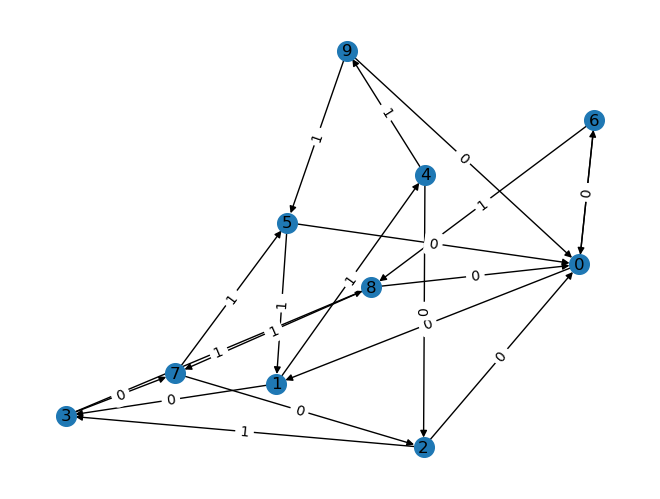

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}


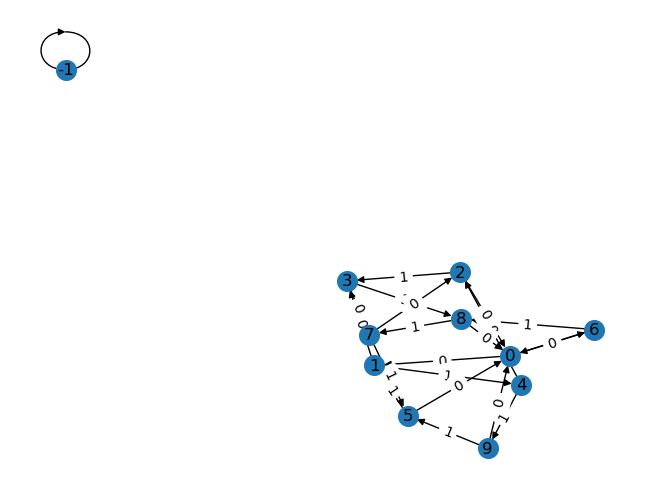

In [295]:
# Define the initial guess for the fixed point calculation
n = 10
game = Arrival(n)
# print(len(game.equations))
x0 = np.zeros(game.n)
x0[0] = 1


In [298]:
print([a for a in zip(game.X,game.equations)])

[(X-1, Min(22528, ceiling(X9/2))), (X0, Min(22528, ceiling(X1/2) + ceiling(X4/2) + ceiling(X5/2) + ceiling(X7/2) + ceiling(X8/2) + 1)), (X1, Min(22528, ceiling(X-1/2) + ceiling(X4/2))), (X2, Min(22528, ceiling(X3/2) + ceiling(X6/2))), (X3, Min(22528, ceiling(X0/2) + ceiling(X1/2))), (X4, Min(22528, ceiling(X0/2))), (X5, Min(22528, ceiling(X6/2) + ceiling(X8/2))), (X6, Min(22528, ceiling(X-1/2))), (X7, Min(22528, ceiling(X2/2) + ceiling(X7/2))), (X8, Min(22528, ceiling(X2/2) + ceiling(X5/2))), (X9, Min(22528, ceiling(X3/2)))]


In [299]:
game.graph.edges

OutEdgeView([(-1, -1), (0, 1), (0, 6), (1, 3), (1, 4), (6, 0), (6, 8), (3, 7), (3, 8), (4, 2), (4, 9), (2, 0), (2, 3), (7, 2), (7, 5), (8, 0), (8, 7), (9, 0), (9, 5), (5, 0), (5, 1)])

In [ ]:

# Calculate the fixed point
fixed_point = calculate_fixed_point(game.evaluate, x0)

print("Fixed point:", fixed_point)

# DANGQIYE METHOD

In [255]:
game.graph.edges 

OutEdgeView([(-1, -1), (0, 14), (0, 11), (14, 22), (11, 3), (11, 14), (1, 2), (1, 12), (2, 21), (2, 17), (12, 22), (12, 7), (21, 19), (21, 17), (17, 9), (17, 16), (3, 10), (3, 12), (10, 15), (10, 13), (4, 9), (4, 20), (9, 16), (9, 4), (20, 22), (20, 17), (5, 6), (5, 10), (6, 4), (6, 8), (8, 22), (8, 9), (7, 4), (7, 12), (22, 8), (22, 21), (16, 18), (16, 9), (15, 5), (15, 10), (13, 10), (13, 22), (18, 15), (18, 16), (19, 3), (19, 1)])